# Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb

from scipy.stats import skew

# Data Preprocessing

In [2]:
data = pd.read_csv("D:/Downloads/Coconut_Production.csv")
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m')
data.set_index('Time', inplace=True)
print(data.head())

            Production
Time                  
2000-01-01       219.0
2000-02-01       219.0
2000-03-01       232.0
2000-04-01       207.0
2000-05-01       222.0


- **Log Transformation**

In [3]:
# Log transformation
data['Production'] = np.log1p(data['Production'])

# Feature Engineering

- **Creating Lag features**

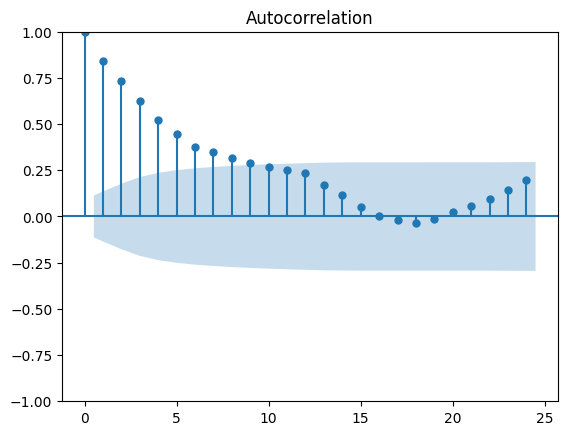

In [4]:
# Lag Features
plot_acf(data['Production'], lags=24)
plt.show() 


In [5]:
def create_lags(data, lags, diff_lags):
    for lag in lags:
        data[f'Lag_{lag}'] = data['Production'].shift(lag)

    for diff_lag in diff_lags:
        data[f'Diff_{diff_lag}'] = data['Production'].diff(diff_lag)  

    return data.dropna()

lags_to_use = [1, 2, 3, 4, 5, 6]
diff_lags_to_use = [1, 2, 3, 4, 5, 6] 

data_featured = create_lags(data.copy(), lags_to_use, diff_lags_to_use)

- **Test - Train split**

In [6]:
# Split data
train_data = data_featured[:-12]
test_data = data_featured[-12:]

X_train = train_data.drop('Production', axis=1)
y_train = train_data['Production']
X_test = test_data.drop('Production', axis=1)
y_test = test_data['Production']


# Model Training

In [7]:
# Initialize the model 
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators= 50,
    max_depth=2,
    learning_rate=0.2,
    reg_alpha=0.1,
    reg_lambda=1.0,
    early_stopping_rounds= 10
)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])


[0]	validation_0-rmse:0.10118	validation_1-rmse:0.11750
[1]	validation_0-rmse:0.08935	validation_1-rmse:0.09850
[2]	validation_0-rmse:0.08005	validation_1-rmse:0.08570
[3]	validation_0-rmse:0.07246	validation_1-rmse:0.07497
[4]	validation_0-rmse:0.06624	validation_1-rmse:0.06850
[5]	validation_0-rmse:0.06081	validation_1-rmse:0.05947
[6]	validation_0-rmse:0.05643	validation_1-rmse:0.05563
[7]	validation_0-rmse:0.05244	validation_1-rmse:0.05216
[8]	validation_0-rmse:0.04904	validation_1-rmse:0.04754
[9]	validation_0-rmse:0.04573	validation_1-rmse:0.04253
[10]	validation_0-rmse:0.04298	validation_1-rmse:0.04014
[11]	validation_0-rmse:0.04082	validation_1-rmse:0.03572
[12]	validation_0-rmse:0.03854	validation_1-rmse:0.03429
[13]	validation_0-rmse:0.03633	validation_1-rmse:0.03125
[14]	validation_0-rmse:0.03475	validation_1-rmse:0.03008
[15]	validation_0-rmse:0.03299	validation_1-rmse:0.02893
[16]	validation_0-rmse:0.03150	validation_1-rmse:0.02706
[17]	validation_0-rmse:0.02981	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

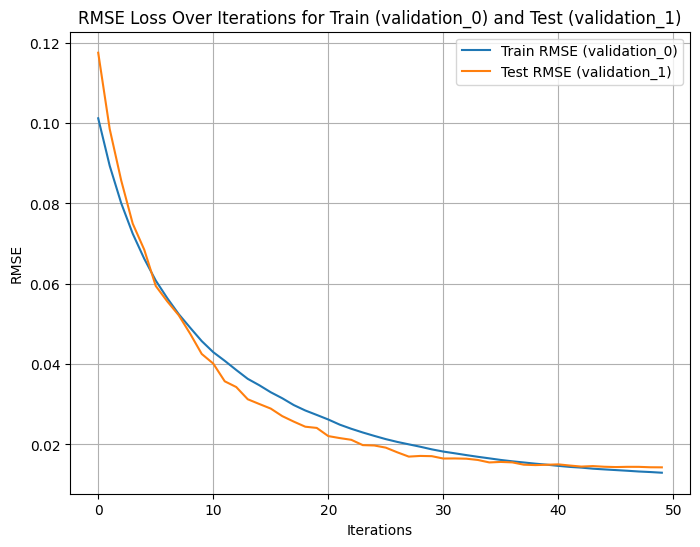

In [8]:
# Retrieve the evals result dictionary from the model
evals_result = model.evals_result()

# Extract train and test RMSE values
train_rmse = evals_result['validation_0']['rmse']
test_rmse = evals_result['validation_1']['rmse']

# Plot the RMSE loss graph for both validation_0 and validation_1
plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Train RMSE (validation_0)')
plt.plot(test_rmse, label='Test RMSE (validation_1)')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE Loss Over Iterations for Train (validation_0) and Test (validation_1)')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

In [9]:
# Predictions and Evaluation
y_pred = model.predict(X_test)


In [10]:
# Inverse transform
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

In [11]:
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"RMSE: {rmse}")


def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
    
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print(f"MAPE: {mape} %")


RMSE: 3.8421822610908007
MAPE: 1.2358943569804097 %


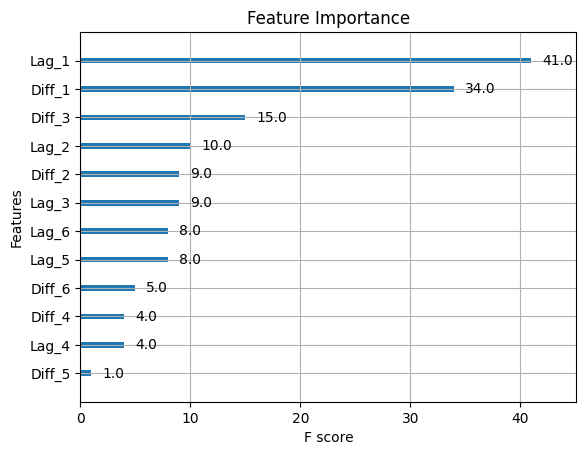

In [12]:
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

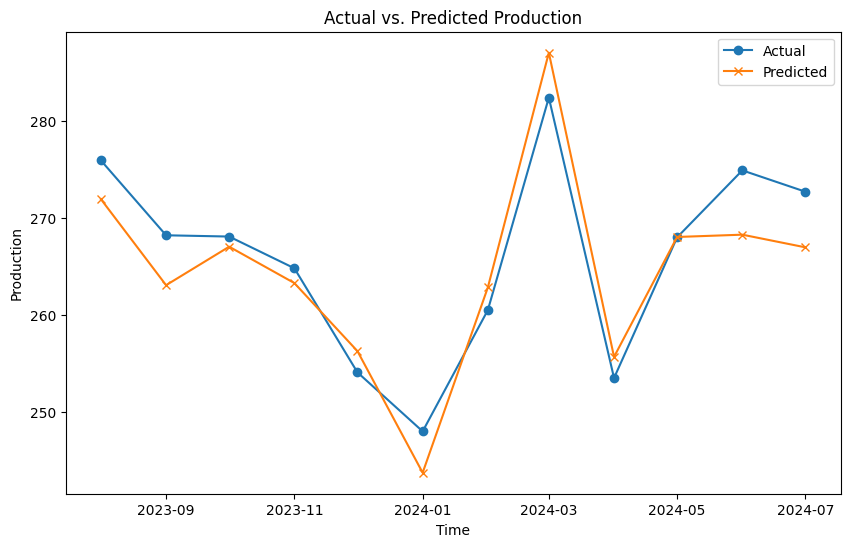

In [13]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original.index, y_test_original, label="Actual", marker='o')
plt.plot(y_test_original.index, y_pred_original, label="Predicted", marker='x')
plt.xlabel("Time")
plt.ylabel("Production")
plt.title("Actual vs. Predicted Production")
plt.legend()
plt.show()

# Future Forecasting for 3 months (short term)

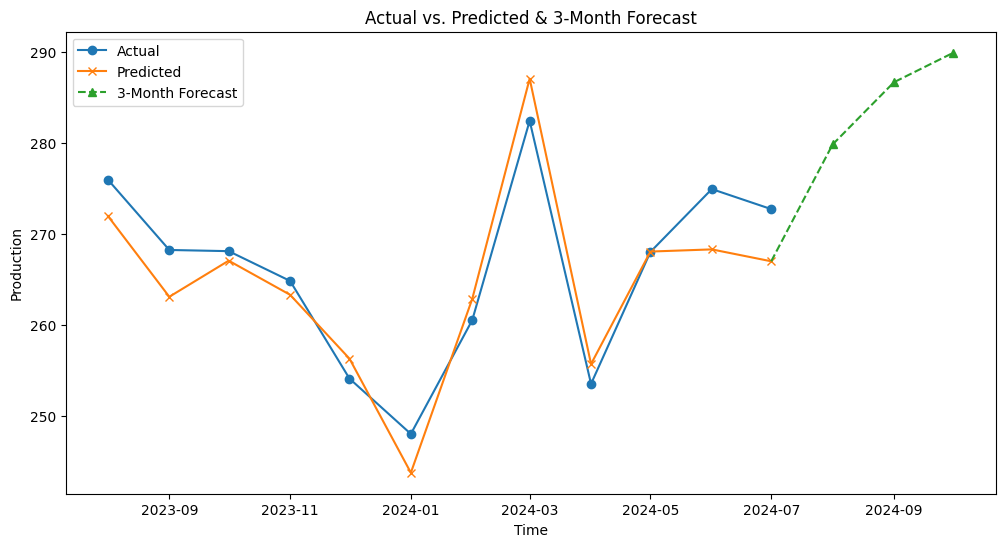

In [14]:
# Future Forecasting (3 months)
future_dates = pd.date_range(start=y_test.index[-1], periods=4, freq='MS')[1:]
future_df = pd.DataFrame(index=future_dates, columns=X_train.columns)

# Create lagged features for future predictions
for lag in lags_to_use:
    future_df[f'Lag_{lag}'] = data['Production'].shift(lag).tail(len(future_dates) + lag).values[lag:]

future_df.fillna(method='ffill', inplace=True)
future_predictions = model.predict(future_df)
future_predictions_original = np.expm1(future_predictions)

# Inverse transform
y_pred_original = pd.Series(np.expm1(y_pred), index=y_test.index)  
future_predictions_original = pd.Series(np.expm1(future_predictions), index=future_dates) 


# Plot with Future Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_original.index, y_test_original, label="Actual", marker='o')
plt.plot(y_pred_original.index, y_pred_original, label="Predicted", marker='x', color='tab:orange')
plt.plot(future_dates, future_predictions_original, label="3-Month Forecast", 
         linestyle="--", marker='^', color='tab:green') 
plt.plot([y_pred_original.index[-1], future_dates[0]], 
         [y_pred_original.iloc[-1], future_predictions_original.iloc[0]], 
         color='tab:green', linestyle='--') 

plt.xlabel("Time")
plt.ylabel("Production")
plt.title("Actual vs. Predicted & 3-Month Forecast")
plt.legend()
plt.show()